
# 02 – Variational Autoencoders (VAE) for Anomaly Detection

**Module:** Anomaly & Fraud Detection  
**Folder:** Ensemble and Advanced Methods

This notebook demonstrates using **Variational Autoencoders (VAE)** for probabilistic latent-space anomaly detection.


## Objective

Build a workflow that:
- Learns latent distribution of normal data
- Uses reconstruction and latent likelihood as anomaly score
- Supports probabilistic thresholding for rare-event detection
- Integrates into production anomaly detection pipelines


## Imports and Setup



In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler

np.random.seed(2010)

## Simulated Dataset

In [85]:
data_normal = np.random.normal(0, 1, size=(1000, 10))
data_anomalies = np.random.normal(5, 1, size=(10, 10))
data = np.vstack([data_normal, data_anomalies])
df = pd.DataFrame(data, columns=[f'feature_{i}' for i in range(data.shape[1])])

In [87]:
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,-0.105704,-0.509297,0.734484,-0.020799,-2.416157,-0.250476,0.720119,-0.662558,-1.741695,-0.759389
1,-0.841154,-2.119870,1.764363,0.836464,0.080998,1.274614,-0.932484,0.551877,0.620475,-0.780760
2,-0.834011,1.922790,-0.667910,0.631669,1.745445,0.809186,0.326955,-0.240587,1.662875,0.165193
3,-1.876209,1.544109,0.491116,0.678227,-0.198855,-0.840782,-1.627437,1.655414,-0.548299,1.969938
4,0.159261,1.124489,-0.121826,-0.815184,-0.384097,1.043807,0.402475,-0.094497,0.830004,1.303220


## Scale Data

In [90]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
input_dim = data_scaled.shape[1]
latent_dim = 5

## Build VAE Model
#### Encoder

In [93]:
inputs = Input(shape=(input_dim,))
h = Dense(16, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#### Sampling layer

In [96]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

#### Decoder

In [99]:
decoder_h = Dense(16, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')
h_decoded = decoder_h(z)
outputs = decoder_mean(h_decoded)

#### VAE model

In [102]:
vae = Model(inputs, outputs)

    import keras
    from keras import ops
    
    # Reconstruction loss
    reconstruction_loss = ops.mean(ops.square(inputs - outputs), axis=-1)
    reconstruction_loss *= input_dim
    
    # KL divergence
    kl_loss = -0.5 * ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var),axis=-1)
    
    vae_loss = ops.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer="adam")


#### Loss: reconstruction + KL divergence

    kl_loss = -0.5 * K.sum(1 + z_log_var - z_mean**2 - K.exp(z_log_var), axis=-1)
    #kl_loss = -0.5 * ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
    reconstruction_loss *= input_dim
    
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    vae_loss = K.mean(reconstruction_loss + kl_loss, axis =0)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

## Train VAE

    vae.fit(data_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

## Compute Reconstruction Error

In [137]:
reconstructions = vae.predict(data_scaled)
df['reconstruction_error'] = np.mean(np.square(data_scaled - reconstructions), axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Thresholding

In [140]:
threshold = np.percentile(df['reconstruction_error'], 95)
df['anomaly_flag'] = (df['reconstruction_error'] > threshold).astype(int)

## Summary

In [143]:
print(df['anomaly_flag'].value_counts())

anomaly_flag
0    959
1     51
Name: count, dtype: int64


## Visualization

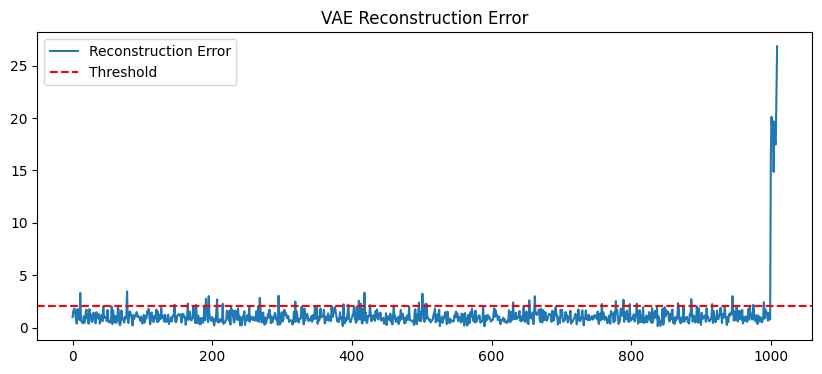

In [146]:
plt.figure(figsize=(10,4))
plt.plot(df['reconstruction_error'], label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.legend()
plt.title('VAE Reconstruction Error')
plt.show()


##  Integration Notes

- VAE models latent distribution and reconstruction  
- Probabilistic latent-space detection helps with rare events  
- Threshold selection is critical  
- Integrates with ensemble pipelines for anomaly detection


## Production Checklist

✔ Train on normal/historical data  
✔ Apply scaling consistently  
✔ Compute reconstruction error for anomaly scoring  
✔ Integrate anomaly flags into monitoring/alerting


## Key Takeaways

- VAE provides probabilistic reconstruction-based anomaly detection  
- Useful for multivariate numeric datasets  
- Supports rare-event detection with probabilistic thresholds


## Next Steps

- Combine VAE scores with classical ML and statistical detectors  
- Monitor reconstruction error drift over time  
- Use for semi-supervised anomaly scoring in production